In [1]:
cd ..

/Users/lisawink/Documents/freiburg


In [2]:
# Investigating Scales < 100m

In [3]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_params
import numpy as np
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import warnings

warnings.filterwarnings('ignore')

In [4]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [5]:
temp

datetime_UTC,2022-09-01 00:00:00+00:00,2022-09-01 01:00:00+00:00,2022-09-01 02:00:00+00:00,2022-09-01 03:00:00+00:00,2022-09-01 04:00:00+00:00,2022-09-01 05:00:00+00:00,2022-09-01 06:00:00+00:00,2022-09-01 07:00:00+00:00,2022-09-01 08:00:00+00:00,2022-09-01 09:00:00+00:00,...,2023-08-31 21:00:00+00:00,2023-08-31 22:00:00+00:00,2023-08-31 23:00:00+00:00,2023-09-01 00:00:00+00:00,2023-09-01 01:00:00+00:00,2023-09-01 02:00:00+00:00,2023-09-01 03:00:00+00:00,2023-09-01 04:00:00+00:00,2023-09-01 05:00:00+00:00,2023-09-01 06:00:00+00:00
station_id,,,,,,,,,,,,,,,,,,,,,
FRASHA,14.78,14.53,14.20,13.73,13.38,12.81,13.81,16.09,17.72,18.89,...,16.54,16.34,18.37,19.90,19.39,18.78,18.85,18.66,18.90,19.18
FRBETZ,16.85,15.73,15.15,14.79,14.34,13.98,14.57,16.08,17.71,18.92,...,18.88,19.17,19.88,19.64,19.18,18.59,18.65,18.09,18.60,19.17
FRBRUH,16.33,15.90,15.40,14.76,14.41,13.87,14.15,15.00,17.27,19.62,...,19.69,19.91,20.42,20.40,19.85,19.22,19.15,18.63,18.91,19.52
FRDIET,13.98,14.53,13.46,13.22,13.08,14.01,15.14,18.82,19.14,19.53,...,18.43,18.85,19.45,19.48,19.00,18.33,18.26,17.62,18.46,18.95
FRDREI,16.61,16.21,16.06,15.54,14.62,14.17,14.99,16.41,17.61,18.23,...,19.33,19.43,19.91,19.92,19.29,18.76,18.68,17.99,18.30,18.78
FREBNE,13.42,13.58,13.09,13.12,12.85,12.23,13.98,16.56,18.37,19.87,...,15.05,15.08,17.47,19.52,19.08,18.38,18.47,17.81,16.14,16.68
FREICH,13.79,13.68,13.73,13.35,12.96,12.83,13.36,15.50,17.73,18.96,...,15.88,16.57,17.11,16.63,16.39,15.76,15.29,15.40,15.59,16.20
FRFRIE,15.22,14.71,14.32,13.86,13.40,13.21,14.30,17.21,21.34,21.91,...,19.14,19.41,19.92,19.93,19.29,18.76,18.70,17.78,18.10,19.03
FRGART,15.91,15.90,15.27,15.14,14.41,13.37,17.11,18.70,19.09,20.33,...,19.25,19.43,19.94,19.91,19.29,18.73,18.61,18.23,18.71,19.23


In [6]:
hiwn = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_winter_nights.csv')

In [15]:
radius = 30

In [16]:
vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']

In [17]:
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)

In [18]:
vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
params = vars.columns
vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

scaler = StandardScaler()
vars_scaled = scaler.fit_transform(vars)
vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)


In [19]:
def stats_multiple_times(radius, var, time):

    #vars['BuSqC_wmean'] = -vars['BuSqC_wmean']
    #vars['BuFra_3D_wmean'] = -vars['BuFra_3D_wmean']
    #vars['BuIBD'] = -vars['BuIBD']
    #vars['BuAdj'] = -vars['BuAdj']

    data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=hiwn.values.flatten(), var_name='time', value_name='temperature')
    data = data.dropna()


    # Compute Spearman correlation
    spearman_corr, p_value = spearmanr(data[var], data['temperature'])

    if len(data) < 3:
        pearson_corr = np.nan
        r_squared = np.nan
        rmse = np.nan
        cooks_d = np.nan
        y_pred = np.nan
    else:
        #Pearson and r squared
        pearson_corr, _ = pearsonr(data[var], data['temperature'])
        X = sm.add_constant(data[var])  # Add constant for regression
        model = sm.OLS(data['temperature'], X).fit()
        r_squared = model.rsquared

        # Get the predicted values (fitted values)
        y_pred = model.fittedvalues

        # Calculate the residuals (errors)
        residuals = data['temperature'] - y_pred

        # Calculate the least squares error (RSS)
        rss = np.sum(residuals ** 2)
        # Calculate the Mean Squared Error (MSE)
        mse = rss / len(data[var])
        # Calculate the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)

        # Compute Cook's distance
        influence = model.get_influence()
        cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance

    return data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred

In [20]:
stats = {}

for param in list(params.values):
    data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, param, hiwn)
    stats[param] = {'spearman_corr': spearman_corr, 'p_value': p_value, 'pearson_corr': pearson_corr, 'r_squared': r_squared, 'rmse': rmse, 'cooks_d': cooks_d, 'y_pred': y_pred}

In [21]:
stats = pd.DataFrame(stats).T

In [26]:
stats

,spearman_corr,p_value,pearson_corr,r_squared,rmse,cooks_d,y_pred
BuAdj,-0.059203,0.10179,-0.160219,0.02567,1.087208,0.016987,2 -0.145845 3 -0.145845 4 -0.14...
BuIBD,-0.422304,0.0,-0.460394,0.211963,0.866508,0.016862,8 -0.501923 11 -0.946619 12 0.20...
BuAre_mean,0.537729,0.0,0.536588,0.287927,0.843844,0.009977,0 -0.266329 1 0.292111 2 -0.63...
BuAre_median,0.341773,0.0,0.405716,0.164605,0.913999,0.003824,0 -0.158133 1 0.257560 2 -0.43...
BuAre_std,-0.003305,0.903094,0.395031,0.15605,0.918668,0.006287,0 -0.302712 1 0.099735 2 -0.30...
...,...,...,...,...,...,...,...
BuCAR,0.510881,0.0,0.494176,0.24421,0.869362,0.007553,0 -0.582858 1 -0.272387 2 -0.45...
SVF_mean,0.103989,0.000122,0.106715,0.011388,0.99429,0.00656,0 0.100648 1 0.133004 2 0.16...
SVF_std,0.382462,0.0,0.231019,0.05337,0.972949,0.003179,0 -0.392739 1 -0.084616 2 -0.46...
SVF_median,0.140116,0.0,0.053069,0.002816,0.998591,0.005699,0 0.056271 1 0.076506 2 0.08...


In [23]:
stats.to_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/hiwn/hiwn_stats_{radius}.csv')

In [10]:
stats = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/hiwn/hiwn_stats_{radius}.csv')

In [75]:
# select stats where mutual information is higher than 
selected_stats = stats[(abs(stats['spearman_corr']) > 0.4)]

In [76]:
selected_stats['Parameter'] = selected_stats.index

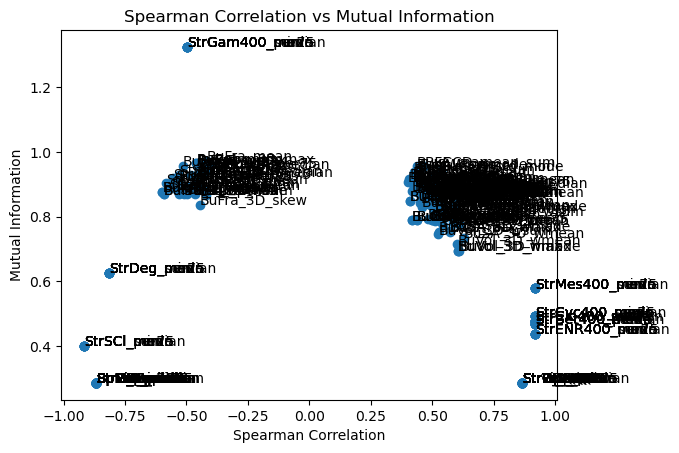

In [35]:
# plot spearman correlation and mutual information on plot for selected stats
# colour by groups

plt.scatter(selected_stats['spearman_corr'], selected_stats['rmse'])
plt.xlabel('Spearman Correlation')
plt.ylabel('Mutual Information')
plt.title('Spearman Correlation vs Mutual Information') 

for i, txt in enumerate(selected_stats['Parameter']):
    plt.annotate(txt, (selected_stats['spearman_corr'].iloc[i], selected_stats['rmse'].iloc[i]))
    
plt.show()

In [31]:
# make interactive plot of plt.scatter(selected_stats['spearman_corr'], selected_stats['rmse'])

alt.Chart(selected_stats).mark_circle().encode(
    x='spearman_corr',
    y='rmse',
    tooltip=['Parameter']
).interactive()

alt.Chart(...)

In [44]:
# make interactive plot of plt.scatter(selected_stats['spearman_corr'], selected_stats['rmse'])

alt.Chart(selected_stats).mark_circle().encode(
    x='spearman_corr',
    y='rmse',
    tooltip=['Parameter']
).interactive()

alt.Chart(...)

In [77]:
items = vars.columns.unique()

# Define mapping of abbreviations to categories
prefix_to_category = {
    'BuAre': 'Dimension', 'BuHt': 'Dimension', 'BuPer': 'Dimension',
    'BuLAL': 'Dimension', 'BuCCD': 'Dimension', 'BuCor': 'Dimension',
    'BuSA' : 'Dimension', 'BuVol': 'Dimension', 'BuSWA': 'Dimension',
    'CyAre': 'Dimension', 'CyInd': 'Dimension', 'BuCWA': 'Shape',
    'BuCon': 'Shape', 'BuElo': 'Shape', 'BuERI': 'Shape',
    'BuFR': 'Shape', 'BuFF': 'Shape', 'BuFD': 'Shape',
    'BuRec': 'Shape', 'BuShI': 'Shape', 'BuSqC': 'Shape',
    'BuSqu': 'Shape', 'BuCir': 'Shape', 'BuHem': 'Shape',
    'BuFra' : 'Shape', 'BuCubo' : 'Shape',  'BuProx' : 'Shape',
    'BuSpi' : 'Shape', 'BuPerC' : 'Shape', 'BuGir' : 'Shape',
    'BuRan' : 'Shape', 'BuAdj': 'Distribution', 'BuIBD': 'Distribution',
    'BuSWR': 'Distribution', 'BuOri': 'Orientation', 'BuAli': 'Orientation',
    'StrAli': 'Orientation', 'StrW': 'Distribution', 'StrWD': 'Distribution',
    'StrOpe': 'Distribution', 'StrHW': 'Distribution', 'StrH': 'Dimension',
    'StrHD': 'Distribution','StrLen': 'Dimension',
    'StrCNS': 'Dimension', 'BpM': 'Intensity', 'StrLin': 'Shape',
    'StrClo400': 'Connectivity', 'StrBet400': 'Connectivity', 
    'StrSCl': 'Connectivity', 'StrCyc400': 'Connectivity', 
    'StrENR400': 'Connectivity', 'StrGam400': 'Connectivity', 
    'StrDeg': 'Connectivity', 'StrMes400': 'Connectivity',
    'SVF': 'Distribution'
}

unique_prefixes = [item.split('_')[0] for item in items]

# Generate categories data dynamically
categories_data = [
    {'Category': prefix_to_category.get(prefix, 'Unknown'), 'Abbrev.': items[i]}
    for i,prefix in enumerate(unique_prefixes)
]

In [78]:
time = hiwn.loc[0]

In [79]:
scaled_subselect = vars[selected_stats['Parameter']]
scaled_subselect[time] = vars[time]

# Create the new structure
rows = []
for station_id, row in scaled_subselect.iterrows():
    y = float(row[time].values)
    for param in scaled_subselect.columns[:-1]:  # Exclude 'y'
        rows.append({
            "station_id": station_id,
            "x": row[param],
            "y": y,
            "Parameter": param
        })

# Create the transformed DataFrame
transformed_df = pd.DataFrame(rows).set_index("station_id")
categories_df = pd.DataFrame(categories_data)

In [80]:
selected_stats = selected_stats.merge(categories_df, how='left', left_on='Parameter', right_on='Abbrev.')

In [83]:
selected_stats

,spearman_corr,p_value,pearson_corr,r_squared,rmse,cooks_d,y_pred,Parameter,Category,Abbrev.,stats
0,-0.422304,0.0,-0.460394,0.211963,0.866508,0.016862,8 -0.501923 11 -0.946619 12 0.20...,BuIBD,Distribution,BuIBD,NaN
1,0.537729,0.0,0.536588,0.287927,0.843844,0.009977,0 -0.266329 1 0.292111 2 -0.63...,BuAre_mean,Dimension,BuAre_mean,mean
2,0.52616,0.0,0.658792,0.434007,0.752325,0.008744,0 -0.482529 1 0.160519 2 -0.79...,BuAre_max,Dimension,BuAre_max,max
3,0.510881,0.0,0.494176,0.24421,0.869362,0.007553,0 -0.582858 1 -0.272387 2 -0.45...,BuAre_sum,Dimension,BuAre_sum,sum
4,0.507084,0.0,0.521104,0.271549,0.853493,0.007704,0 -0.316720 1 0.323625 2 -0.67...,BuAre_per75,Dimension,BuAre_per75,per75
...,...,...,...,...,...,...,...,...,...,...,...
333,-0.916913,0.0,-0.958938,0.919562,0.401894,0.059929,2 0.291033 7 2.150529 9 -1.17...,StrSCl_sum,Connectivity,StrSCl_sum,sum
334,-0.916913,0.0,-0.958938,0.919562,0.401894,0.059929,2 0.291033 7 2.150529 9 -1.17...,StrSCl_mode,Connectivity,StrSCl_mode,mode
335,-0.916913,0.0,-0.958938,0.919562,0.401894,0.059929,2 0.291033 7 2.150529 9 -1.17...,StrSCl_per25,Connectivity,StrSCl_per25,per25
336,-0.916913,0.0,-0.958938,0.919562,0.401894,0.059929,2 0.291033 7 2.150529 9 -1.17...,StrSCl_per75,Connectivity,StrSCl_per75,per75


In [82]:
params =  transformed_df
params['station_id'] = params.index
selected_stats['stats'] = selected_stats['Parameter'].str.split('_').str[1]

# Left plot: R-squared vs Gradient scatter plot
selection = alt.selection_point(fields=['Parameter'], empty='none', on='click', toggle='event.shiftKey')  # Selection on param
selection1 = alt.selection_point(fields=['Category'], bind='legend', on='click', toggle='event.shiftKey')
selection2 = alt.selection_point(fields=['stats'], bind='legend', on='click', toggle='event.shiftKey')

# Step 2: Add category coloring to scatter plot
category_colors = alt.Scale(scheme='category10')  # Use a predefined Altair color scheme

scatter_plot = alt.Chart(selected_stats).mark_point(size=100).encode(
    x=alt.X('spearman_corr:Q', title='Spearman Correlation'),
    y=alt.Y('rmse:Q', title='RMSE'),
    color=alt.condition(selection1, 'Category:N', alt.value('lightgray')),
    shape=alt.Shape('stats:N', title='Statistic'),
    opacity=alt.condition(selection2, alt.value(1), alt.value(0.2)),
    tooltip=['Parameter', 'Category', 'spearman_corr', 'rmse']
).add_params(
    selection, selection1, selection2
).properties(
    title='Mutual Information vs Spearman Correlation',
    width=400,
    height=300
).interactive()

# Step 3: Right plot remains the same
points = alt.Chart(params).transform_filter(
    selection
).mark_point().encode(
    x=alt.X('x:Q', title='X'),
    y=alt.Y('y:Q', title='Temperature'),
    tooltip=['x', 'y']
)

# Create the text labels for the station IDs
text_labels = alt.Chart(params).transform_filter(
    selection
).mark_text(
    align='left', 
    baseline='middle', 
    dx=5,  # Slightly offset the text so it doesn't overlap the point
).encode(
    x='x',
    y='y',
    text='station_id'  # Use station_id as the label
)

# add drop down box for Parameter


regression_plot = (points + text_labels).properties(
    title='Linear Regression Plot',
    width=400,
    height=300
).interactive()

# Combine the plots
final_chart = alt.vconcat(scatter_plot, regression_plot)
final_chart.show()

alt.VConcatChart(...)

In [84]:
params =  transformed_df
params['station_id'] = params.index
selected_stats['stats'] = selected_stats['Parameter'].str.split('_').str[1]

# Left plot: R-squared vs Gradient scatter plot
selection = alt.selection_point(fields=['Parameter'], empty='none', on='click', toggle='event.shiftKey')  # Selection on param
selection1 = alt.selection_point(fields=['Category'], bind='legend', on='click', toggle='event.shiftKey')
selection2 = alt.selection_point(fields=['stats'], bind='legend', on='click', toggle='event.shiftKey')

# Step 2: Add category coloring to scatter plot
category_colors = alt.Scale(scheme='category10')  # Use a predefined Altair color scheme

scatter_plot = alt.Chart(selected_stats).mark_point(size=100).encode(
    x=alt.X('spearman_corr:Q', title='Spearman Correlation'),
    y=alt.Y('cooks_d:Q', title="Cook's distance"),
    color=alt.condition(selection1, 'Category:N', alt.value('lightgray')),
    shape=alt.Shape('stats:N', title='Statistic'),
    opacity=alt.condition(selection2, alt.value(1), alt.value(0.2)),
    tooltip=['Parameter', 'Category', 'spearman_corr', 'rmse']
).add_params(
    selection, selection1, selection2
).properties(
    title='Mutual Information vs Spearman Correlation',
    width=400,
    height=300
).interactive()

# Step 3: Right plot remains the same
points = alt.Chart(params).transform_filter(
    selection
).mark_point().encode(
    x=alt.X('x:Q', title='X'),
    y=alt.Y('y:Q', title='Temperature'),
    tooltip=['x', 'y']
)

# Create the text labels for the station IDs
text_labels = alt.Chart(params).transform_filter(
    selection
).mark_text(
    align='left', 
    baseline='middle', 
    dx=5,  # Slightly offset the text so it doesn't overlap the point
).encode(
    x='x',
    y='y',
    text='station_id'  # Use station_id as the label
)

# add drop down box for Parameter


regression_plot = (points + text_labels).properties(
    title='Linear Regression Plot',
    width=400,
    height=300
).interactive()

# Combine the plots
final_chart = alt.vconcat(scatter_plot, regression_plot)
final_chart.show()

alt.VConcatChart(...)